## Cargar los datos

In [1]:
from Data import load_dataset_pair

(queryset1, dataset1) = load_dataset_pair("descriptores/MEL128", 21573, 33545, 128)
print("Q1={} R1={}".format(queryset1.shape, dataset1.shape))

(queryset2, dataset2) = load_dataset_pair("descriptores/SIFT", 2886, 202088, 128)
print("Q2={} R2={}".format(queryset2.shape, dataset2.shape))

(queryset3, dataset3) = load_dataset_pair("descriptores/VGG19", 842, 10171, 4096)
print("Q3={} R3={}".format(queryset3.shape, dataset3.shape))

datasets = [(queryset1, dataset1), (queryset2, dataset2), (queryset3, dataset3)]


Q1=(21573, 128) R1=(33545, 128)
Q2=(2886, 128) R2=(202088, 128)
Q3=(842, 4096) R3=(10171, 4096)


## Medir desempeño de los índices
Se construyen los índices y se prueban distintos parámetros para cada uno, se almacenan los resultados en arreglos.

In [2]:
from Index import Linear, KDTree, KMeansTree
from Results import obtener_curva


# construir el indice linear scan y buscar los NN
linear = Linear(dataset3)
print("construccion linear scan = {:.1f}".format(linear.build_time))
lscan_dists, lscan_time = linear.search(queryset3)
print("busqueda linear scan = {:.1f}".format(lscan_time))

# obtener curvas para KD-Tree
curvas_kdTree = []
leyenda_kdTree = []

# número de árboles a probar
num_trees = [5, 10, 20, 30, 40, 50]
for trees in num_trees:
    
    # construir el indice KD-Tree
    kdtree = KDTree(dataset3, trees=trees)
    print('construccion {:d}-KDTree = {:.1f}'.format(trees, kdtree.build_time))

    # obtener curva y agregar al arreglo
    efectividad, eficiencia = obtener_curva(kdtree, queryset3, lscan_time, lscan_dists)
    curvas_kdTree.append([efectividad, eficiencia])
    leyenda_kdTree.append('{:d} árboles'.format(trees))
    print('{:d} busquedas {:d}-KDTree = {:.1f}'.format(len(eficiencia) - 1, trees, sum(eficiencia) * lscan_time))

# obtener curvas para K-Means Tree
curvas_kmeans = []
leyenda_kmeans = []

# número de ramas a probar
num_branches = [5, 10, 20, 30, 40, 50]
for branches in num_branches:
    
    # construir el indice K-Means Tree
    kmeanstree = KMeansTree(dataset3, branching=branches)
    print('construccion {:d}-KMeansTree = {:.1f}'.format(branches, kmeanstree.build_time))

    # obtener curva y agregar al arreglo
    efectividad, eficiencia = obtener_curva(kmeanstree, queryset3, lscan_time, lscan_dists)
    curvas_kmeans.append([efectividad, eficiencia])
    leyenda_kmeans.append('{:d} ramas'.format(branches))
    print('{:d} busquedas {:d}-KMeansTree = {:.1f}'.format(len(eficiencia) - 1, branches, sum(eficiencia) * lscan_time))


construccion linear scan=0.0
busqueda linear scan=18.2
construccion 5-KDTree = 3.4
14 busquedas 5-KDTree = 35.0
construccion 10-KDTree = 6.9
12 busquedas 10-KDTree = 9.1
construccion 20-KDTree = 13.5
14 busquedas 20-KDTree = 40.8
construccion 40-KDTree = 33.1
14 busquedas 40-KDTree = 52.1
construccion 60-KDTree = 41.9
13 busquedas 60-KDTree = 26.9
construccion 5-KMeansTree = 24.8
11 busquedas 5-KMeansTree = 45.6
construccion 10-KMeansTree = 36.5
12 busquedas 10-KMeansTree = 37.2
construccion 15-KMeansTree = 65.3
12 busquedas 15-KMeansTree = 31.1
construccion 20-KMeansTree = 45.2
12 busquedas 20-KMeansTree = 28.8
construccion 30-KMeansTree = 146.5
13 busquedas 30-KMeansTree = 41.1


## Graficar los resultados

hacer doble click sobre la imagen para ver en definición completa


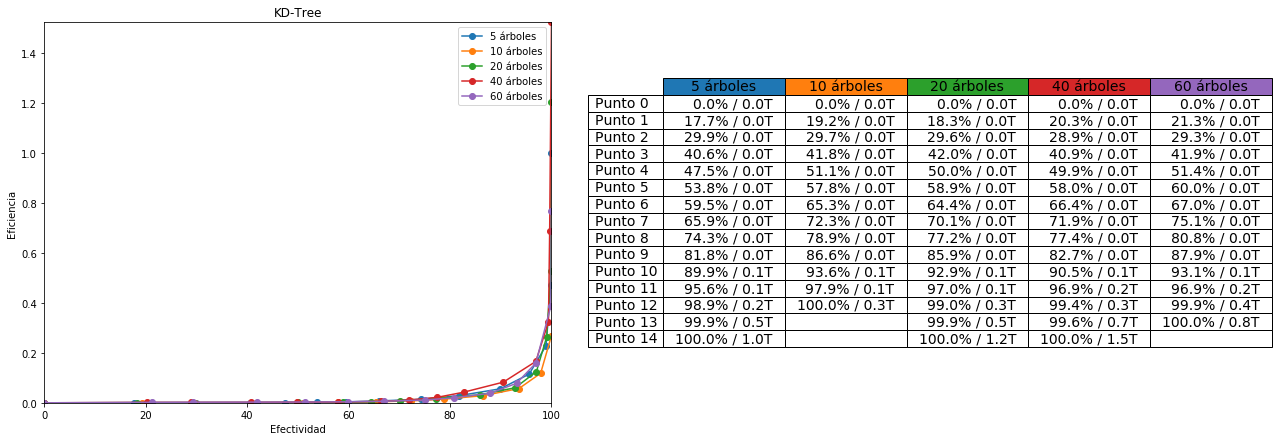

hacer doble click sobre la imagen para ver en definición completa


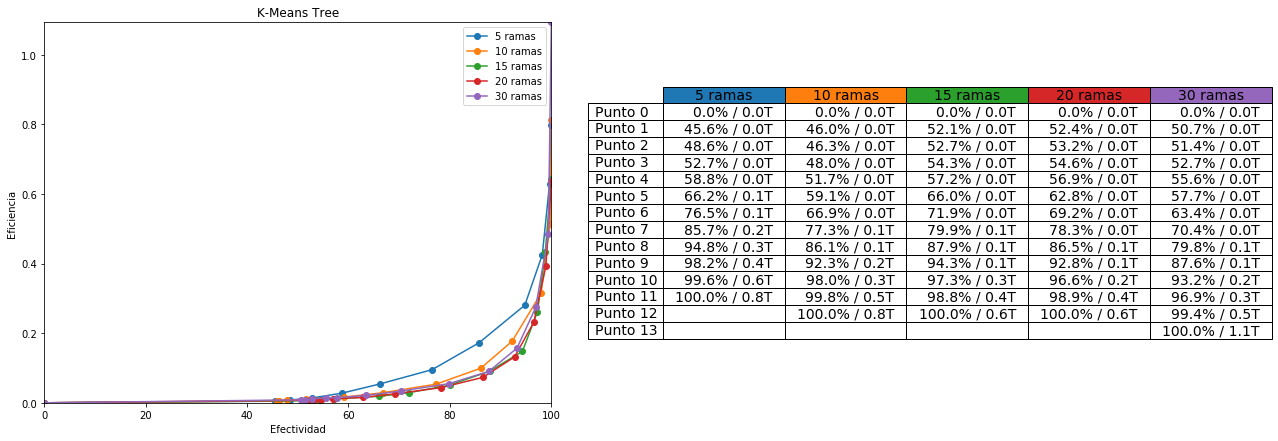

In [96]:
import matplotlib.pyplot as plt

def graficar_curvas(curvas, leyenda, titulo):
    plt.figure(figsize=(20, 7))
    
    # curvas
    plt.subplot(1,2,1)
    
    # graficar curvas y obtener límite en y
    max_efic = 1.0
    for efectividad, eficiencia in curvas:
        p = plt.plot(efectividad, eficiencia, 'o-')
        max_efic = max(max_efic, max(eficiencia))

    # configuración
    plt.xlabel('Efectividad')
    plt.ylabel('Eficiencia')
    
    plt.xlim([0, 100])
    plt.ylim([0, max_efic])
    
    plt.legend(leyenda)
    plt.title(titulo)
    
    
    # tabla
    plt.subplot(1,2,2)
    
    # obtener número de filas de la tabla
    rows = 0
    for efectividad, _ in curvas:
        rows = max(rows, len(efectividad))

    # generar texto de la tabla
    cells_text = [[] for _ in range(rows)]
    for efectividad, eficiencia in curvas:
        
        # agregar datos de la columna
        for i in range(len(efectividad)):
            cells_text[i].append('%1.1f%% / %1.1fT' % (efectividad[i], eficiencia[i]))
        
        # rellenar con vacío
        for i in range(len(efectividad), rows):
            cells_text[i].append('')
    
    # esconder gráfico vacío
    plt.axis('tight')
    plt.axis('off')
    
    # graficar tabla
    colors = ["C%i" % i for i in range(len(leyenda))]
    table = plt.table(cellText=cells_text,
                      colLabels=leyenda,
                      colColours=colors,
                      rowLabels=["Punto %i" % i for i in range(rows)],
                      loc='center left')
    
    # agrandar tamaño letra
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.2, 1.4)

    print("Hacer doble click sobre la imagen para ver en definición completa")
    plt.show()
    return


# graficar los datos
graficar_curvas(curvas_kdTree, leyenda_kdTree, "KD-Tree")
graficar_curvas(curvas_kmeans, leyenda_kmeans, "K-Means Tree")